Рассмотрим начально-краевую задачу для одномерного уравнения теплопроводности:

$$
\frac{\partial u}{\partial t} = \frac{\partial^2 u}{\partial x^2}
$$


c краевыми условиями $(0 \leqslant x \leqslant 1)$

$$
u(0, t) = u(1, t) = 0
$$

и начальным условием

$$
u(x, 0) = \sin{\pi x}\;.
$$

Требуется написать программу, строящую решение в области $0 \leqslant x \leqslant 1$ и $t \geqslant 0$ с использованием конечно-разностной схемы (схему выбираете самостоятельно, но не чисто явную схемы на четырехтотечном шаблоне).
Решение визуализировать, сравнить с точным решением.
Обосновать выбор конечно-разностной схемы, указать условия устойчивости и порядок сходимости.

*Решение*  

Будем имплементировать явный шаблон. Сначала подключим библиотеки:

In [1]:
import numpy as np
import matplotlib.pyplot as plt

Определим начальное условие:

In [2]:
u_0 = lambda x: np.sin(np.pi * x)

Условие устойчивости для явной схемы:  
$$ \frac{\tau}{h^2} \leqslant \frac{1}{2} $$

Зададим область решения и шаги сетки по пространству и времени:

In [3]:
T_ = 2
h = 1e-1
tau = 0.3e-2
x_space = np.arange(0, 1 + h, h)
t_space = np.arange(0, T_ + tau, tau)

Проверим выполнение условия устойчивости:

In [4]:
tau/h**2 <= 1/2

True

Воспользуемся meshgrid для удобства:

In [5]:
T, X = np.meshgrid(t_space, x_space)

Исследуемая сетка имеет размер:

In [6]:
X.shape

(11, 668)

Первая координата - пространство, вторая - время.

Зададим массив для аппрокмирующей функции на сетке, а также инициализируем значения, соответствующие граничным условиям:

In [7]:
y = np.empty_like(X)
y[:, 0] = u_0(X[:, 0])
y[0, :] = 0
y[-1, :] = 0

Определим функцию, реализирующую явный шаблон:

In [8]:
from numba import njit

@njit
def explicit_stencil(grid, tau, h):
    y = grid.copy()
    for n in range(y.shape[1] - 1):
        for j in range(1, y.shape[0] - 1):
            y[j, n+1] = tau * (y[j+1, n] - 2 * y[j, n] + y[j-1, n]) / h**2 + y[j, n]

    return y

Аппроксимируем функцию:

In [9]:
y = explicit_stencil(y, tau, h)

Аналитическим решением исходной задачи:  
$$
\begin{cases} 
\frac{\partial u}{\partial t} = \frac{\partial^2 u}{\partial x^2} \\
u(0, t) = u(1, t) = 0 \\
u(x, 0) = \sin{\pi x} 
\end{cases}
$$ 

является функция:
$$ u(x, t) = e^{-\pi^2 t} \sin(\pi x)$$

Зададим эту функцию и таблицу её значений:

In [10]:
u = lambda x, t: np.exp(-np.pi**2 * t) * np.sin(np.pi * x)
u_val = u(X, T)

Посчитаем ошибку: возьмём максимальный модуль разности значений истинной функции и функции-приближения:

In [11]:
np.max(np.abs(u_val - y))

0.0024405661321932892

Отобразим эти функции на графиках:

In [12]:
def plot_3d_subplots(X, T, u_val, y): 
    fig = plt.figure(figsize=(20, 8))
    ax = fig.add_subplot(1, 2, 1, projection='3d')
    ax.plot_surface(X, T, u_val)
    ax.view_init(30, 150)
    ax.set_xlabel('x')
    ax.set_ylabel('t')
    ax.set_zlabel('u')
    ax.set_title('Истинная функция')

    ax = fig.add_subplot(1, 2, 2, projection='3d')
    ax.plot_surface(X, T, y)
    ax.view_init(30, 150)
    ax.set_xlabel('x')
    ax.set_ylabel('t')
    ax.set_zlabel('y')
    ax.set_title('Аппроксимация')

    plt.show()

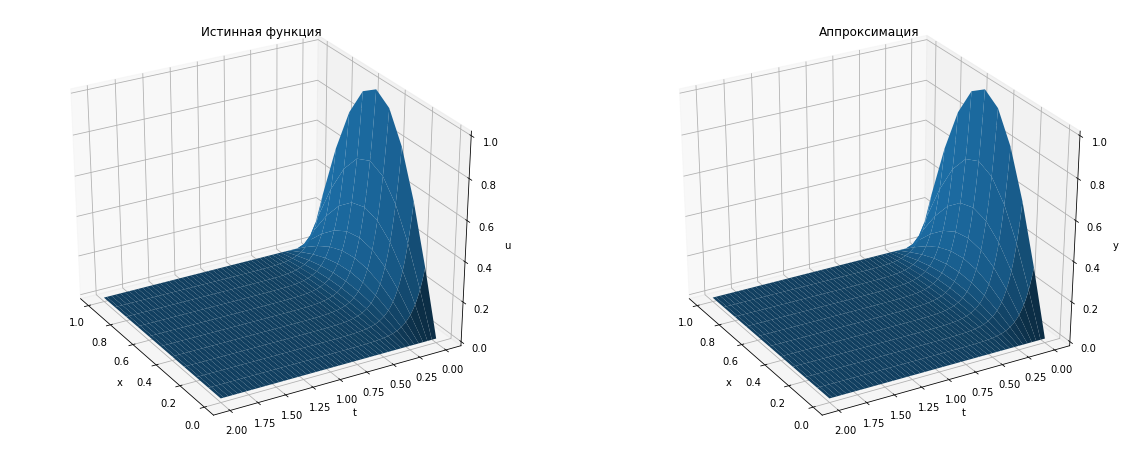

In [13]:
plot_3d_subplots(X, T, u_val, y)

Теперь рассмотрим случай, когда условие устойчивости не выполняется, т.е. 
$$ \frac{\tau}{h^2} > \frac{1}{2} $$

In [14]:
T_ = 2
h = 1e-1
tau = 0.7e-2
x_space = np.arange(0, 1 + h, h)
t_space = np.arange(0, T_ + tau, tau)

tau/h**2 <= 0.5

False

In [15]:
T, X = np.meshgrid(t_space, x_space)

y = np.empty_like(X)
y[:, 0] = u_0(X[:, 0])
y[0, :] = 0
y[-1, :] = 0

In [16]:
y = explicit_stencil(y, tau, h)
u_val = u(X, T)

Аналогичным образом посчитаем ошибку и отобразим функции на графиках:

In [17]:
np.max(np.abs(u_val - y))

4.7593288986980696e+50

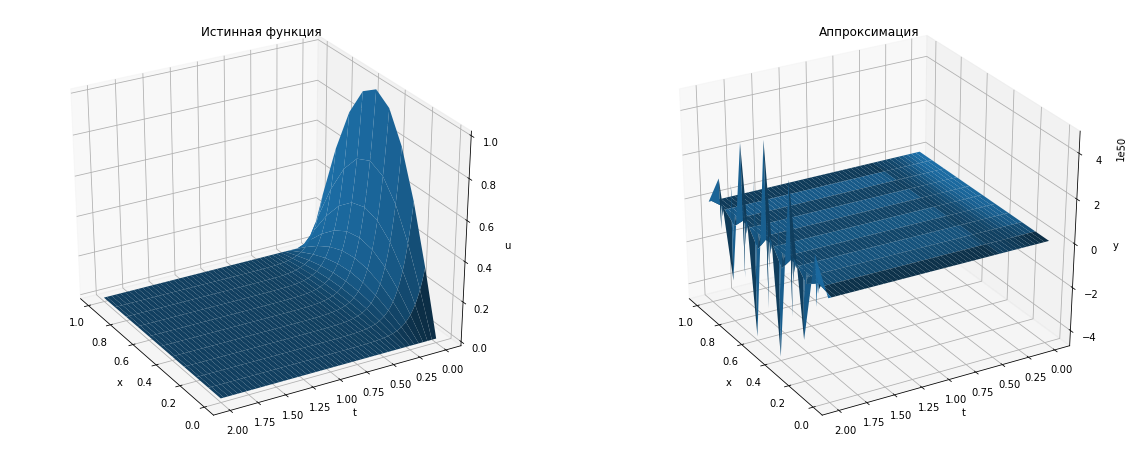

In [18]:
plot_3d_subplots(X, T, u_val, y)

Как видно по величине ошибки ($ 10^{50} $) и по графикам, метод расходится.

Известно, что порядок сходимости явного метода - это $ O(\tau + h^{2}) $. Проверим это экспериментально.  
Определим функцию, которая по заданным $ \tau $ и $ h $ строит сетку, апрроксимирует функцию и возвращает ошибку (максимум модуля разности истинной функции и приближения):

In [19]:
def calc_error(tau, h, T_=2):
    x_space = np.arange(0, 1 + h, h)
    t_space = np.arange(0, T_ + tau, tau)

    T, X = np.meshgrid(t_space, x_space)
    y = np.empty_like(X)
    y[:, 0] = u_0(X[:, 0])
    y[0, :] = 0
    y[-1, :] = 0

    y = explicit_stencil(y, tau, h)
    u_val = u(X, T)
    
    return np.max(np.abs(u_val - y))

Зафиксируем $ \tau $ и будем последовательно менять $ h $ (в таких значениях, чтобы соблюдалось условие устойчивости):

In [20]:
h = 1e-1
tau = 0.1e-4

In [21]:
h_range = [h/2**i for i in range(1, 5)]
error_list = []
for h_ in h_range:
    error_list.append(calc_error(tau, h_))

In [22]:
error_list

[0.0007384596821826128,
 0.0001709696269060479,
 2.9124432581018045e-05,
 6.33515776177207e-06]

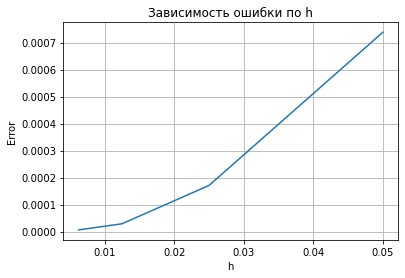

In [23]:
plt.plot(h_range, error_list)
plt.xlabel('h')
plt.ylabel('Error')
plt.title('Зависимость ошибки по h')
plt.grid()
plt.show()

Видно, что ошибка имеет квадратичный порядок по $ h $.  
Аналогично для $ \tau $ :

In [24]:
h = 1e-1
tau = 0.1e-2

In [25]:
tau_range = [tau/2**i for i in range(1, 10)]
error_list = []
for tau_ in tau_range:
    error_list.append(calc_error(tau_, h))

In [26]:
error_list

[0.002126068853744112,
 0.0025775814242305906,
 0.002802991439856961,
 0.002915609997530988,
 0.00297189771735884,
 0.003000036170444531,
 0.0030141040386725826,
 0.0030211376374102428,
 0.0030246543522378655]

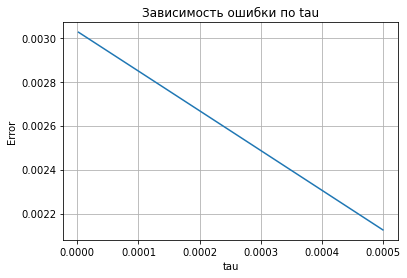

In [27]:
plt.plot(tau_range, error_list)
plt.xlabel('tau')
plt.ylabel('Error')
plt.title('Зависимость ошибки по tau')
plt.grid()
plt.show()

Значения ошибки мало меняются, тем не менее видно, что она имеет линейный порядок по $ \tau $